# Imports

In [1]:
import requests
import json
import pickle
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from sklearn.linear_model import LinearRegression

RUN_FROM = 'uni_wifi' #'bastion'

if RUN_FROM == 'bastion' : URL, HEADERS = 'http://fission:31001/', None
if RUN_FROM == 'uni_wifi': URL, HEADERS =  'http://172.26.135.52:9090/', {'HOST': 'fission'}

# Functions

In [2]:
def weather_to_pd(station_id: str, start_year: int, end_year: int, verb=False) -> pd.DataFrame:
    resp_dict = json.loads(requests.get(URL+f'weather/{station_id}/{start_year}/{end_year}', headers=HEADERS).text)
    data = resp_dict['Data']
    if verb : print(f'Called weather api, fetched {len(data)} lines')
    return pd.DataFrame.from_records(data)

In [3]:
def get_stream_to_pd(api: str, station_id: str, size: int, radius_km: int, verb=False) -> pd.DataFrame:
    resp_dict = json.loads(requests.get(URL+api+f'/{station_id}/{size}/{radius_km}', headers=HEADERS).text)

    count=0
    status, token, new_data = resp_dict['Status'], resp_dict['Token'], resp_dict['Data']
    data = [new_data[i]['_source'] for i in range(len(new_data))]
    if verb : print(f'Called {api} api, fetched {len(new_data)} lines')


    while (status == 200) and (new_data != []) :
        count+=1
        resp_dict = json.loads(requests.get(URL+f'stream/'+token, headers=HEADERS).text)
        status, token, new_data = resp_dict['Status'], resp_dict['Token'], resp_dict['Data']
        if verb : print(f'Called stream {count} times, fetched {len(new_data)} new lines')
        data += [new_data[i]['_source'] for i in range(len(new_data))]

    if verb: print(f'Fetched a total of {len(data)}lines')
    return pd.DataFrame.from_records(data)

# Tests

## Joined data creation

In [8]:
df_weather_full = weather_to_pd(station_id='95003', start_year =2014, end_year=2019, verb=True)

Called weather api, fetched 1822 lines


In [9]:
df_weather = df_weather_full.copy()

weather_num_cols = ['UV', 'Min Temp', 'Max Temp', 'WindSpeed', 'Min Humid', 'Max Humid', 'Rain', 'Pan-Rain', 'Evapo-Rain']

for col in weather_num_cols:
    df_weather[col] = pd.to_numeric(df_weather[col])

df_weather = df_weather.rename(columns={'Date':'date'})
df_weather['date'] = pd.to_datetime(df_weather['date'], format='%d/%m/%Y').dt.date
df_weather = df_weather.drop(columns=['created_at','source', 'Station Name'])

df_weather.dtypes

UV            float64
Max Humid       int64
Min Temp      float64
WindSpeed     float64
Min Humid       int64
date           object
Rain          float64
Pan-Rain      float64
Max Temp      float64
state          object
Evapo-Rain    float64
dtype: object

In [10]:
df_crime_full = get_stream_to_pd(api='crime', station_id='95003', size=8000, radius_km=800, verb=True)

Called crime api, fetched 8000 lines
Called stream 1 times, fetched 8000 new lines
Called stream 2 times, fetched 2622 new lines
Called stream 3 times, fetched 0 new lines
Fetched a total of 18622lines


In [11]:
resp = requests.get(URL+'stations').json()
df_stations = pd.DataFrame.from_records(resp['Data'], index='Station ID')
df_stations.loc[95003,'Station Name']

'BUSHY PARK (BUSHY PARK ESTATES)'

In [12]:
df_crime_full.head(3)

,reported_date,suburb,postcode,description_1,description_2,description_3,offence_count
0,2013-02-19T00:00:00,MOUNT GAMBIER,5290,OFFENCES AGAINST THE PERSON,OTHER OFFENCES AGAINST THE PERSON,Dangerous or negligent acts,1.0
1,2013-02-21T00:00:00,GLENCOE,5291,OFFENCES AGAINST PROPERTY,PROPERTY DAMAGE AND ENVIRONMENTAL,Other property damage and environmental,1.0
2,2013-02-21T00:00:00,GLENCOE,5291,OFFENCES AGAINST PROPERTY,THEFT AND RELATED OFFENCES,Theft/Illegal Use of MV,1.0


In [13]:
df_crime = df_crime_full.groupby(['reported_date', 'description_1'])['offence_count'].sum().reset_index()

df_crime = df_crime.rename(columns={'reported_date':'date'})
df_crime['date'] = pd.to_datetime(df_crime['date']).dt.date

df_crime.dtypes

date              object
description_1     object
offence_count    float64
dtype: object

In [14]:
df_crime.head(3)

,date,description_1,offence_count
0,2012-07-01,OFFENCES AGAINST PROPERTY,4.0
1,2012-07-02,OFFENCES AGAINST PROPERTY,7.0
2,2012-07-02,OFFENCES AGAINST THE PERSON,1.0


In [15]:
df_weather.head(3)

,UV,Max Humid,Min Temp,WindSpeed,Min Humid,date,Rain,Pan-Rain,Max Temp,state,Evapo-Rain
0,13.84,95,6.2,5.54,39,2014-01-01,0.0,4.0,24.3,tas,4.5
1,34.54,80,10.2,6.32,44,2014-01-02,0.8,5.0,19.9,tas,5.8
2,29.90,95,3.8,4.03,31,2014-01-03,0.0,4.2,24.0,tas,5.8


In [16]:
df = pd.merge(df_weather, df_crime, on='date', how='inner')
df.shape

(2999, 13)

In [17]:
df.head(3)

,UV,Max Humid,Min Temp,WindSpeed,Min Humid,date,Rain,Pan-Rain,Max Temp,state,Evapo-Rain,description_1,offence_count
0,13.84,95,6.2,5.54,39,2014-01-01,0.0,4.0,24.3,tas,4.5,OFFENCES AGAINST PROPERTY,7.0
1,34.54,80,10.2,6.32,44,2014-01-02,0.8,5.0,19.9,tas,5.8,OFFENCES AGAINST PROPERTY,9.0
2,34.54,80,10.2,6.32,44,2014-01-02,0.8,5.0,19.9,tas,5.8,OFFENCES AGAINST THE PERSON,2.0


## Linear Regression

In [18]:
df['description_1'].unique()

array(['OFFENCES AGAINST PROPERTY', 'OFFENCES AGAINST THE PERSON'],
      dtype=object)

### On persons

In [22]:
df_pers = df[df['description_1'] == 'OFFENCES AGAINST THE PERSON']
df_pers = df_pers.drop(columns=['description_1', 'date', 'state'])
df_pers.head(4)

,UV,Max Humid,Min Temp,WindSpeed,Min Humid,Rain,Pan-Rain,Max Temp,Evapo-Rain,offence_count
2,34.54,80,10.2,6.32,44,0.8,5.0,19.9,5.8,2.0
4,29.90,95,3.8,4.03,31,0.0,4.2,24.0,5.8,1.0
6,31.58,88,8.4,6.50,37,10.2,4.8,18.0,5.3,1.0
8,13.47,95,9.8,5.25,36,1.8,5.8,21.9,4.2,4.0


In [23]:
lin_model_pers = LinearRegression()
lin_model_pers.fit(df_pers.drop(columns='offence_count').values, df_pers['offence_count'])
pd.DataFrame({'Predictors': df_pers.columns[:-1], 'Coefficient': lin_model_pers.coef_})

,Predictors,Coefficient
0,UV,0.000458
1,Max Humid,-0.002849
2,Min Temp,-0.000246
3,WindSpeed,0.002318
4,Min Humid,-0.000830
5,Rain,-0.009130
6,Pan-Rain,-0.001443
7,Max Temp,0.000042
8,Evapo-Rain,0.034988


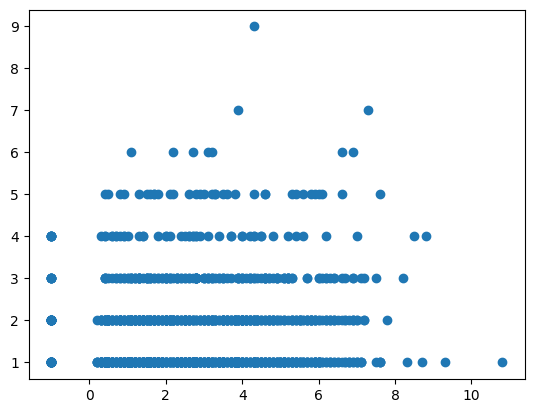

In [24]:
sub_lin_model_pers = LinearRegression()
sub_lin_model_pers.fit(df_pers[['Evapo-Rain']].values, df_pers['offence_count'])

# plt.scatter(df_pers[['Evapo-Rain','offence_count']].values)
plt.scatter(df_pers['Evapo-Rain'],df_pers['offence_count'])

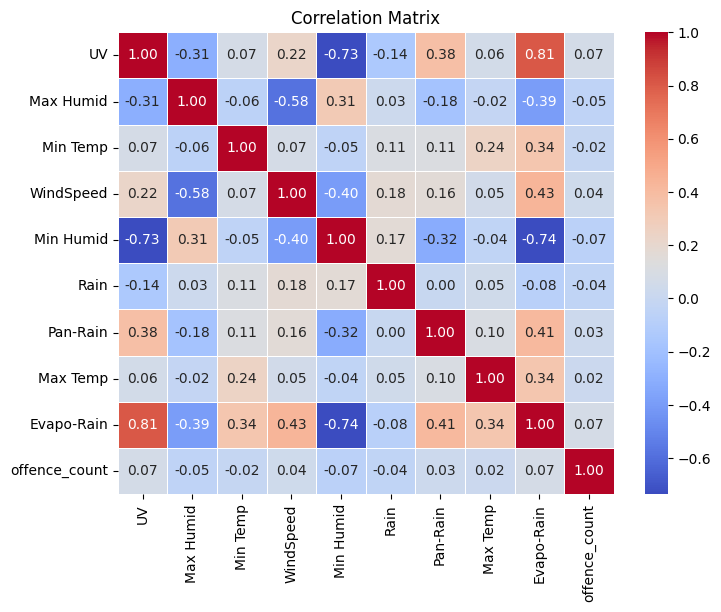

In [25]:
corr_table_pers = df_pers.corr(method='pearson')

plt.figure(figsize=(8, 6))
sns.heatmap(corr_table_pers, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

In [26]:
predictor = 'Evapo-Rain'  # 'UV', 'Min Temp', 'Max Temp', 'WindSpeed', 'Min Humid', 'Max Humid', 'Rain', 'Pan-Rain', 'Evapo-Rain'
r, p_value = pearsonr(df_pers[predictor], df_pers['offence_count'])
print(f'With a correlation of {r}, the p-value associated to H0:"There is no correlation" is {p_value}')

With a correlation of 0.0735085614494382, the p-value associated to H0:"There is no correlation" is 0.009702480362140742


## On Properties

In [27]:
df_pers = df[df['description_1'] == 'OFFENCES AGAINST PROPERTY']
df_pers = df_pers.drop(columns=['description_1', 'date', 'state'])
df_pers.head(4)

,UV,Max Humid,Min Temp,WindSpeed,Min Humid,Rain,Pan-Rain,Max Temp,Evapo-Rain,offence_count
0,13.84,95,6.2,5.54,39,0.0,4.0,24.3,4.5,7.0
1,34.54,80,10.2,6.32,44,0.8,5.0,19.9,5.8,9.0
3,29.90,95,3.8,4.03,31,0.0,4.2,24.0,5.8,6.0
5,31.58,88,8.4,6.50,37,10.2,4.8,18.0,5.3,4.0


In [28]:
lin_model_pers = LinearRegression()
lin_model_pers.fit(df_pers.drop(columns='offence_count').values, df_pers['offence_count'])
pd.DataFrame({'Predictors': df_pers.columns[:-1], 'Coefficient': lin_model_pers.coef_})

,Predictors,Coefficient
0,UV,-0.014941
1,Max Humid,-0.013570
2,Min Temp,0.000367
3,WindSpeed,-0.027696
4,Min Humid,-0.002559
5,Rain,0.007096
6,Pan-Rain,0.025765
7,Max Temp,0.000111
8,Evapo-Rain,0.064835


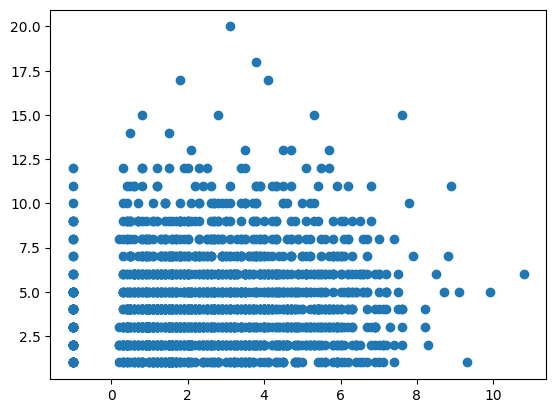

In [29]:
sub_lin_model_pers = LinearRegression()
sub_lin_model_pers.fit(df_pers[['Evapo-Rain']].values, df_pers['offence_count'])

# plt.scatter(df_pers[['Evapo-Rain','offence_count']].values)
plt.scatter(df_pers['Evapo-Rain'],df_pers['offence_count'])

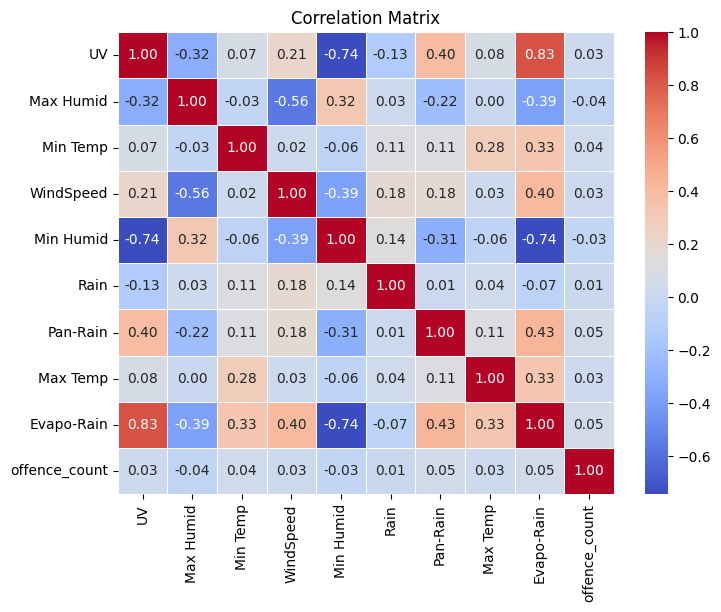

In [30]:
corr_table_pers = df_pers.corr(method='pearson')

plt.figure(figsize=(8, 6))
sns.heatmap(corr_table_pers, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

In [31]:
predictor = 'Evapo-Rain'  # 'UV', 'Min Temp', 'Max Temp', 'WindSpeed', 'Min Humid', 'Max Humid', 'Rain', 'Pan-Rain', 'Evapo-Rain'
r, p_value = pearsonr(df_pers[predictor], df_pers['offence_count'])
print(f'With a correlation of {r}, the p-value associated to H0:"There is no correlation" is {p_value}')

With a correlation of 0.05074460467448215, the p-value associated to H0:"There is no correlation" is 0.03317776565502933


# Saving and Sending lin_model_perss to API

In [ ]:
with open(f'lin_model_crime_pers_VIC.pkl', 'wb') as f:
    pickle.dump(lin_model_pers, f)